In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import scipy.optimize as spo
import scipy.special as sps

In [19]:
#This function takes a 3d array of (size along each dimension = N_side) poisson values of lamda = n_bar and the desired
# power spectrum pk_cl and returns another 3d array of the same dimension with the n(x) following pk_cl(k)

def GonzNuevo(box_p, N_side, L_side, n_bar, pk_cl, k_for_P, pseudo_fact):
    #Now pixel size of the box
    del_x = L_side/(N_side - 1)

    #Now let's get the density contrast
    box_delx = (box_p - n_bar)/n_bar

    #Now let's take the fourier transform of box_delx to get box_delk
    box_delk = pseudo_fact * np.fft.fftn(box_delx, norm='ortho')

    temp_factor = np.power(del_x * np.sqrt(N_side)/np.sqrt(2 * np.pi), 3)
    box_delk = temp_factor * box_delk

    #Getting the corresponding k values along 1d axis
    k_vals = 2 * np.pi * np.fft.fftfreq(N_side, d=del_x) # This is removed here---- , d= del_x)    

    #Power spectrum of the Poisson field box_delx
    #First I create a 3d array of same shape as box_delk, with values equal
    #to |k| value corresponding to same position in box_delk.
    temb_mesh = np.meshgrid(k_vals, k_vals, k_vals, indexing='ij')
    modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)

    #Now let's iterate through the k_for_P and find the index of modk_grid with k
    #that falls between and find power spectrum pk.
    pk = np.zeros(len(k_for_P)-1)
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        pk[i] = np.average(np.absolute(box_delk[np.where((modk_grid >= k1) & (modk_grid < k2))]) ** 2)
    
    box_vol = (N_side * del_x)**3
    pk = pk/box_vol * np.power(np.sqrt(2 * np.pi), 3)

    #----------------------------------------------------------------------------------------------------
    #plotting the pks
    k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.plot(k_for_P_mid, pk)
    ax2.plot(k_for_P_mid, pk_cl)

    ax1.set_xlabel('k')
    ax1.set_ylabel(r'$P_{pois}(k)$')
    ax2.set_xlabel('k')
    ax2.set_ylabel(r'$P_{cl}(k)$')
    #----------------------------------------------------------------------------------------------------
    
    #Make a new delk.
    box_delk_new = np.copy(box_delk)

    #modify the delk using the chosen power spectrum
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        temp_ind = np.where((modk_grid >= k1) & (modk_grid < k2))
        box_delk_new[temp_ind] = box_delk[temp_ind] * (np.sqrt(pk_cl[i] + pk[i])) / np.sqrt(pk[i])

    #Now we need to inverse fourier transfor box_delk_new to get box_delx_new
    box_delx_new = pseudo_fact * np.fft.ifftn(box_delk_new, norm='ortho')
    
    #Now again we have to add the factors
    del_k = 2 * np.pi/(N_side * del_x)
    temp_factor = np.power(del_k * np.sqrt(N_side)/np.sqrt(2 * np.pi), 3)
    box_delx_new = temp_factor * box_delx_new

    #Now to get the new n(x)
    #box_GN = np.asarray(np.round(n_bar * (1 + box_delx_new)), dtype='int64')
    box_GN = n_bar * (1 + box_delx_new) #np.where(box_delx_new<0, 0, box_delx_new))  #I have made all the negative values in box_delx_new to 0


    #-------------------------------------------------------------------------------------------------------
    #finding the new power spectrum
    pk_new = np.zeros(len(k_for_P)-1)
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        pk_new[i] = np.average(np.absolute(box_delk_new[np.where((modk_grid >= k1) & (modk_grid < k2))]) ** 2)
    
    pk_new = pk_new/box_vol * np.power(np.sqrt(2 * np.pi), 3)

    #plotting the new psd vs the given one
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.plot(k_for_P_mid, pk_new, label=r'$P_{new}(k)$')
    ax1.plot(k_for_P_mid, pk_cl, label=r'$P_{cl}(k)$')
    ax1.set_xlabel('k')
    ax1.set_ylabel(r'$P(k)$')
    ax1.legend()
    ax2.plot(k_for_P_mid, pk_new-pk_cl, label=r'$P_{new}(k) - P_{cl}(k)$')
    ax2.set_xlabel('k')
    ax2.legend()
    #-------------------------------------------------------------------------------------------------------

    return box_GN

## Where it all begins

In [30]:
#Let's create a well defined box to hold the number of particles, box_p. 
N_side = 32
#Choose the mean number of particles, n_bar
n_bar = 5
#Choose the total physical length of the box
L_side = 31
#Now pixel size of the box
del_x = L_side/(N_side - 1)

#Populate box_p with number of particles drawn from gaussian with mean n_bar.
box_p = np.random.normal(loc=n_bar, scale=0.1, size=(N_side, N_side, N_side))

#Lets make the k's needed for the power spectrum.
k_min = 0 #2 * np.pi/(N_side * del_x) # changing minimum to 0 to see the effect
k_max = 2 * np.pi/(2 * del_x) * np.sqrt(3)#Changing the max k value to match the max in k grid.
assert (N_side % 2 == 0)
k_for_P = np.linspace(k_min, k_max, N_side//2)

#Now we have to make a desired power spectrum pk_cl
delta_of_k = 1.5
const_of_k = 1
k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2
pk_cl = np.power(const_of_k * k_for_P_mid, -delta_of_k)

#This is a pseudo factor that i give to observe the effect of factor in 2pcf and box_GN distribution
pseudo_fact = 1

box_GN = GonzNuevo(box_p, N_side, L_side, n_bar, pk_cl, k_for_P, pseudo_fact)
plt.close('all')

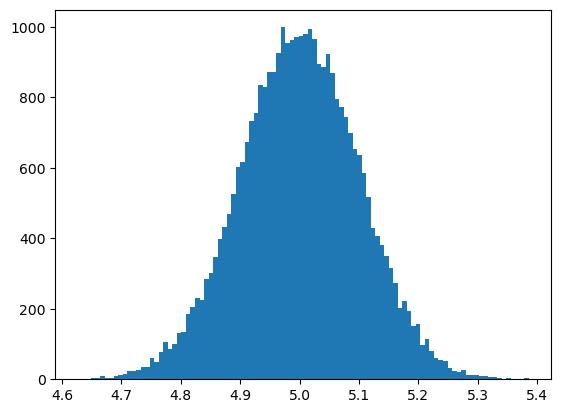

In [32]:
plt.hist(np.real(box_GN.flatten()), bins=100);
plt.hist(box_p.flatten(), bins=100);
# plt.xlim(-1,15)

## 2pcf measurement - Corrfunc

In [5]:
#Let me make another box, which we will fill with Poisson drawn numbers.
#This will be used as the random catalog in our analysis.
N_side_r = N_side
n_bar_r = n_bar

box_r = np.random.poisson(lam=n_bar_r, size=(N_side_r, N_side_r, N_side_r))

#Now we can find the correlation function of box_GN. Using the same way.
bins = np.arange(1, N_side)
x1, y1, z1 = np.asarray(np.meshgrid(np.arange(N_side), np.arange(N_side), np.arange(N_side), indexing='xy'), dtype='float')
x1 = x1.flatten()
y1 = y1.flatten()
z1 = z1.flatten()
weights1 = np.asarray(box_GN.flatten(), dtype='float')

result_DD_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, weight_type='pair_product', periodic=False, output_ravg=True)

#Lets find similarly the DR and RR.
weights2 = np.asarray(box_r.flatten(), dtype='float')
x_r, y_r, z_r = np.asarray(np.meshgrid(np.arange(N_side_r), np.arange(N_side_r), np.arange(N_side_r), indexing='xy'), dtype='float')
x_r = x_r.flatten()
y_r = y_r.flatten()
z_r = z_r.flatten()
result_RR_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x_r, Y1 = y_r, Z1 = z_r, weights1 = weights2, weight_type='pair_product', periodic=False, output_ravg=True)

result_DR_GN = DD(autocorr=0, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, X2 = x_r, Y2 = y_r, Z2 = z_r, weights2 = weights2, \
               weight_type='pair_product', periodic=False, output_ravg=True)

#Now with DD, RR and DR that we obtained, we will find the xi(r), two point correlation function.
#We need normalisation also, which is the total number of pairs.
DD_count_GN = (result_DD_GN['npairs']*result_DD_GN['weightavg'])/2
DR_count_GN = result_DR_GN['npairs']*result_DR_GN['weightavg']
RR_count_GN = (result_RR_GN['npairs']*result_RR_GN['weightavg'])/2
DD_total_GN = (np.sum(weights1) * (np.sum(weights1) - 1))/2
RR_total_GN = (np.sum(weights2) * (np.sum(weights2) - 1))/2
DR_total_GN = (np.sum(weights1) * np.sum(weights2))

Xi_GN = (DD_count_GN/DD_total_GN - 2 * DR_count_GN/DR_total_GN + RR_count_GN/RR_total_GN)/(RR_count_GN/RR_total_GN)

/tmp/ipykernel_2055526/4187650135.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  weights1 = np.asarray(box_GN.flatten(), dtype='float')
[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


k_for_P is :  [0.         0.36275987 0.72551975 1.08827962 1.45103949 1.81379936
 2.17655924 2.53931911 2.90207898 3.26483886 3.62759873 3.9903586
 4.35311847 4.71587835 5.07863822 5.44139809]
k_for_P_mid is :  [0.18137994 0.54413981 0.90689968 1.26965955 1.63241943 1.9951793
 2.35793917 2.72069905 3.08345892 3.44621879 3.80897866 4.17173854
 4.53449841 4.89725828 5.26001816]


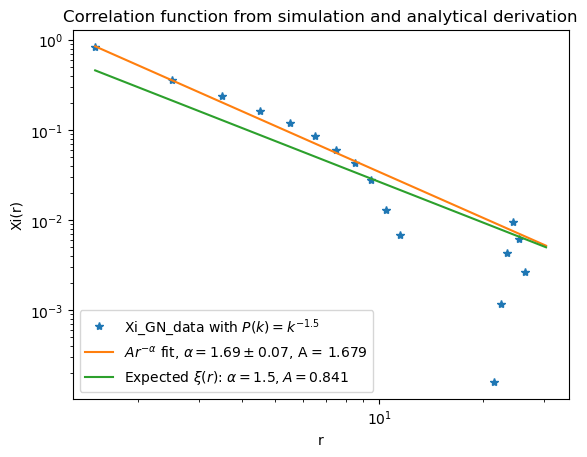

In [6]:
#Fitting the Xi_GN with a power law function to check what degree of correlation we get
def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

r_bins = bins * del_x
r_mid = (r_bins[:-1] + r_bins[1:])/2

popt, pcov = spo.curve_fit(pow_func, r_mid, Xi_GN)

fig, ax = plt.subplots()

ax.plot(r_mid, Xi_GN, '*', label = r"Xi_GN_data with $P(k) = k^{{-{}}}$".format(delta_of_k))
ax.plot(r_mid, pow_func(r_mid, popt[0], popt[1]), label=r'$Ar^{{-\alpha}}$ fit, $\alpha = {}\pm{}$, A = {}'.format(np.round(popt[1],3),np.round(np.sqrt(pcov[1,1]), 2), np.round(popt[0],3)))
ax.set_xlabel('r')
ax.set_ylabel('Xi(r)')

#Expected correlation function
alpha_expect = 3 - delta_of_k
A_expect = (sps.gamma(alpha_expect/2))/ (const_of_k * np.power(2, 1 - alpha_expect/2) * sps.gamma((3 - alpha_expect)/2))
ax.plot(r_mid, pow_func(r_mid, A_expect, alpha_expect), label=r"Expected $\xi(r)$: $\alpha = {}, A = {}$".format(np.round(alpha_expect,3), np.round(A_expect,3)))
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_title("Correlation function from simulation and analytical derivation")

print("k_for_P is : ",k_for_P)
print("k_for_P_mid is : ", k_for_P_mid)

## 2pcf measurement - Direct

/tmp/ipykernel_2055911/1272841990.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_corr[i] = np.sum((box_GN[:,:dim-temp_x,:]-box_mean) * (box_GN[:,temp_x:,:]-box_mean))/ (N_side** 3)


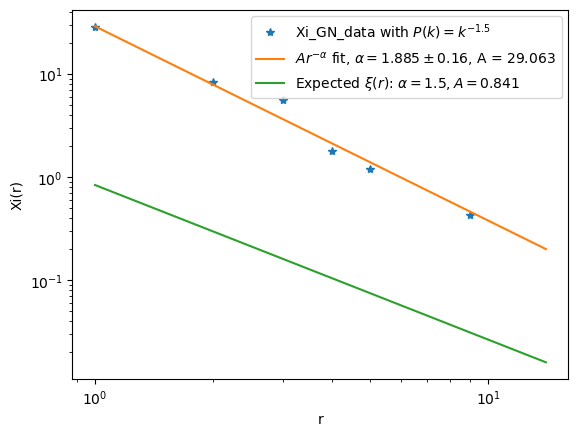

In [29]:
box_mean = np.average(box_GN)

# I am finding the 2pcf along axis 0 here
dim = np.shape(box_GN)[0]
temp_x_min = 1
temp_x_max = 15
temp_corr = np.zeros(temp_x_max - temp_x_min)
for i, temp_x in enumerate(range(temp_x_min, temp_x_max)):
    temp_corr[i] = np.sum((box_GN[:,:dim-temp_x,:]-box_mean) * (box_GN[:,temp_x:,:]-box_mean))/ (N_side** 3)

def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)
temp_x = np.arange(temp_x_min, temp_x_max) * (del_x)

temp_popt, temp_pcov = spo.curve_fit(pow_func, temp_x, temp_corr)

plt.plot(temp_x, temp_corr, '*', label = r"Xi_GN_data with $P(k) = k^{{-{}}}$".format(delta_of_k))
plt.plot(temp_x, pow_func(temp_x, temp_popt[0], temp_popt[1]), label=r'$Ar^{{-\alpha}}$ fit, $\alpha = {}\pm{}$, A = {}'.format(np.round(temp_popt[1],3),np.round(np.sqrt(temp_pcov[1,1]), 2), \
                                                                                                                    np.round(temp_popt[0],3)))
#Expected correlation function
alpha_expect = 3 - delta_of_k
A_expect = (sps.gamma(alpha_expect/2))/ (const_of_k * np.power(2, 1 - alpha_expect/2) * sps.gamma((3 - alpha_expect)/2))
plt.plot(temp_x, pow_func(temp_x, A_expect, alpha_expect), label=r"Expected $\xi(r)$: $\alpha = {}, A = {}$".format(np.round(alpha_expect,3), np.round(A_expect,3)))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('r')
plt.ylabel('Xi(r)')
plt.legend()